In [1]:
import numpy
from netCDF4 import Dataset
import matplotlib.pyplot as mp
import matplotlib.colors as mc
import matplotlib.cm as cm
import mpl_toolkits.mplot3d
import matplotlib
import scipy.ndimage
import datetime

import itertools
import random
import numpy.random
import scipy.stats
import os

mp.rcParams.update({'mathtext.default': 'regular'})

from mpl_toolkits import basemap
import mpl_toolkits.axes_grid1

degree_sign = u'\u00B0'
% matplotlib inline

In [2]:
model_names = numpy.array(( \
'ACCESS1-0', \
'ACCESS1-3', \
'bcc-csm1-1-m', \
'bcc-csm1-1', \
'BNU-ESM', \
'CanESM2', \
'CCSM4', \
'CESM1-BGC', \
'CESM1-CAM5', \
'CMCC-CESM', \
'CMCC-CM', \
'CMCC-CMS', \
'CNRM-CM5', \
'CSIRO-Mk3-6-0', \
'EC-EARTH', \
'FGOALS-g2', \
'GFDL-CM3', \
'GFDL-ESM2G', \
'GFDL-ESM2M', \
'GISS-E2-H', \
'GISS-E2-R', \
'HadGEM2-AO', \
'HadGEM2-CC', \
'HadGEM2-ES', \
'inmcm4', \
'IPSL-CM5A-LR', \
'IPSL-CM5A-MR', \
'IPSL-CM5B-LR', \
'MIROC5', \
'MIROC-ESM-CHEM', \
'MIROC-ESM', \
'MPI-ESM-LR', \
'MPI-ESM-MR', \
'MRI-CGCM3', \
'NorESM1-ME', \
'NorESM1-M' ))
nmods = len(model_names)

In [3]:
pr_lat_lo, pr_lat_hi, pr_lon_lo, pr_lon_hi = 30., 45., 232.5, 248; region = 'CA'
ts_lat_lo, ts_lat_hi, ts_lon_lo, ts_lon_hi = -30., 10., 155., 270.; region = 'tropacific'
ua_lat_lo, ua_lat_hi, ua_lon_lo, ua_lon_hi = 20., 50., 170., 250.; region = 'midlatpacific'

season='djf'; SEASON='DJF'

In [8]:
# OPEN TS DATASET
ncfile = Dataset('../../../DATA/cmip5_data/ts/djf/NorESM1-M_ts_1980-10_climatology_djf.nc', 'r', format='NETCDF4')

ts_data_orig = ncfile.variables['ts'][:]
ts_lat = ncfile.variables['lat'][:]
ts_lon = ncfile.variables['lon'][:]

# pull out lat/lon indices
ts_lat_inds = numpy.where((ts_lat>=ts_lat_lo) & (ts_lat<=ts_lat_hi))[0]
ts_lon_inds = numpy.where((ts_lon>=ts_lon_lo) & (ts_lon<=ts_lon_hi))[0]
ts_regional_lat_vals = ts_lat[ts_lat_inds[0]:(ts_lat_inds[-1]+1)]
ts_regional_lon_vals = ts_lon[ts_lon_inds[0]:(ts_lon_inds[-1]+1)]    

ts_data = ts_data_orig[ts_lat_inds[0]:(ts_lat_inds[-1]+1), ts_lon_inds[0]:(ts_lon_inds[-1]+1)]
ts_regional_nlat, ts_regional_nlon = ts_data.shape
global_nlat, global_nlon = ts_data_orig.shape[0:2]
global_lat_vals = ts_lat[:]
global_lon_vals = ts_lon[:]

# Open data

In [10]:
ncal_latlon = numpy.load('../../../DATA/ncal_latlon_array.npy')
ccal_latlon = numpy.load('../../../DATA/ccal_latlon_array.npy')
scal_latlon = numpy.load('../../../DATA/scal_latlon_array.npy')

In [11]:
DATESTRING = '2018-05-19_14:44:37'

save_dir = '../../../DATA/subensemble_data/'
save_filename = 'pareto_front_results_'+DATESTRING+'_k1to5_emergent_constraint_domains.npy'

save_dict = numpy.load(save_dir+save_filename)

pareto_set_collect_2d_list = save_dict[()]['pareto_set_collect_2d_list']
pareto_set_collect_3d_list = save_dict[()]['pareto_set_collect_3d_list']

bias_values_subensembles_x = save_dict[()]['bias_values_subensembles_x']
bias_values_subensembles_y = save_dict[()]['bias_values_subensembles_y']
bias_values_subensembles_z = save_dict[()]['bias_values_subensembles_z']

bias_values_subensembles_x_LENS = save_dict[()]['bias_values_subensembles_x_LENS']
bias_values_subensembles_y_LENS = save_dict[()]['bias_values_subensembles_y_LENS']
bias_values_subensembles_z_LENS = save_dict[()]['bias_values_subensembles_z_LENS']

col1_orig = numpy.copy(bias_values_subensembles_x)
col2_orig = numpy.copy(bias_values_subensembles_y)
col3_orig = numpy.copy(bias_values_subensembles_z)

#
k = save_dict[()]['k']
N_pareto_loops = save_dict[()]['N_pareto_loops']

N_ens = save_dict[()]['N_ens']
N_ens_LENS = save_dict[()]['N_ens_LENS']

model_combinations = save_dict[()]['model_combinations']
model_combinations_LENS = save_dict[()]['model_combinations_LENS']

dict_pr = save_dict[()]['dict_x']
dict_ts = save_dict[()]['dict_y']
dict_ua = save_dict[()]['dict_z']

pareto_set_sizes_3d = save_dict[()]['pareto_set_sizes_3d']

# Loop through pareto_set_collect and take all PO subensembles for 3D

In [12]:
# now get all the subensembles in pareto_set_collect, take their mean, and look at end-of-century precip change
# GET INFO ON OPTIMAL PARETO SETS, ETC.

pareto_set_collect = pareto_set_collect_3d_list[0]

# SAVE THE MODELS THAT MAKE UP THE PARETO FRONT
n_optima = pareto_set_collect.shape[0]
optimal_subensembles = []
optimal_subensembles_indices = []
optimal_subensembles_sizes = []

optimal_y_subensembles = numpy.empty((N_pareto_loops, k), dtype=object)
optimal_x_subensembles = numpy.empty((N_pareto_loops, k), dtype=object)
optimal_z_subensembles = numpy.empty((N_pareto_loops, k), dtype=object)

optimal_y_pareto_combos = numpy.zeros(N_pareto_loops, dtype=numpy.int)
optimal_x_pareto_combos = numpy.zeros(N_pareto_loops, dtype=numpy.int)
optimal_z_pareto_combos = numpy.zeros(N_pareto_loops, dtype=numpy.int)

# collect all optimal subensembles
for i in range(n_optima):
    pareto_combo = numpy.where((col1_orig==pareto_set_collect[i,0]) & (col2_orig==pareto_set_collect[i,1]) & (col3_orig==pareto_set_collect[i,2]))[0][0]
    optimal_subensembles.append(model_names[model_combinations[pareto_combo][:]])
    optimal_subensembles_indices.append(model_combinations[pareto_combo][:])
    optimal_subensembles_sizes.append(optimal_subensembles_indices[-1].size)

# calculate precip change over each optimal subensemble
all_po_subensembles_hist = numpy.zeros((len(optimal_subensembles), dict_pr['nlat'], dict_pr['nlon']))
all_po_subensembles_eoc = numpy.zeros((len(optimal_subensembles), dict_pr['nlat'], dict_pr['nlon']))
for ens in range(n_optima):
    ens_array = optimal_subensembles[ens]
    individual_subensembles_hist = numpy.zeros((ens_array.size, dict_pr['nlat'], dict_pr['nlon']))
    individual_subensembles_eoc = numpy.zeros((ens_array.size, dict_pr['nlat'], dict_pr['nlon']))
    for member in range(ens_array.size):
        individual_subensembles_hist[member,:,:] = dict_pr['fields_hist_mods'][numpy.where(optimal_subensembles[ens][member]==model_names)[0][0],:,:]
        individual_subensembles_eoc[member,:,:] = dict_pr['fields_eoc_mods'][numpy.where(optimal_subensembles[ens][member]==model_names)[0][0],:,:]
    all_po_subensembles_hist[ens,:,:] = numpy.mean(individual_subensembles_hist, axis=0)
    all_po_subensembles_eoc[ens,:,:] = numpy.mean(individual_subensembles_eoc, axis=0)

# Now stored as optimal_subensembles_indices and optimal_subensembles

In [13]:
#print(optimal_subensembles_indices)
# find ccal indices on this graph
print(ncal_latlon)
print(dict_pr['lats'])

[[236.25  38.75]
 [236.25  41.25]
 [238.75  41.25]]
[31.25 33.75 36.25 38.75 41.25 43.75]


In [15]:
# loop through the optimal subensembles
# pull out ccal, ncal, scal lat/lon indices, take average
# look at them

# get latlon combo
latlon_indices_ncal = numpy.zeros((ncal_latlon.shape),dtype=int)
latlon_indices_ccal = numpy.zeros((ccal_latlon.shape),dtype=int)
latlon_indices_scal = numpy.zeros((scal_latlon.shape),dtype=int)

for i in range(ncal_latlon.shape[0]):
    latlon_indices_ncal[i,0] = numpy.where(ncal_latlon[i,0]==dict_pr['lons'])[0][0]
    latlon_indices_ncal[i,1] = numpy.where(ncal_latlon[i,1]==dict_pr['lats'])[0][0]

    latlon_indices_ccal[i,0] = numpy.where(ccal_latlon[i,0]==dict_pr['lons'])[0][0]
    latlon_indices_ccal[i,1] = numpy.where(ccal_latlon[i,1]==dict_pr['lats'])[0][0]

    latlon_indices_scal[i,0] = numpy.where(scal_latlon[i,0]==dict_pr['lons'])[0][0]
    latlon_indices_scal[i,1] = numpy.where(scal_latlon[i,1]==dict_pr['lats'])[0][0]

all_po_subensembles_hist[0,latlon_indices_ncal[:,0],latlon_indices_ncal[:,1]]

array([1.59443754, 0.95802164, 0.88177902])

# Taking Pareto-optimal subensembles

In [16]:
all_po_subensembles_hist_ncal = all_po_subensembles_hist[:,latlon_indices_ncal[:,1],latlon_indices_ncal[:,0]].mean(axis=1)
all_po_subensembles_hist_ccal = all_po_subensembles_hist[:,latlon_indices_ccal[:,1],latlon_indices_ccal[:,0]].mean(axis=1)
all_po_subensembles_hist_scal = all_po_subensembles_hist[:,latlon_indices_scal[:,1],latlon_indices_scal[:,0]].mean(axis=1)

all_po_subensembles_eoc_ncal = all_po_subensembles_eoc[:,latlon_indices_ncal[:,1],latlon_indices_ncal[:,0]].mean(axis=1)
all_po_subensembles_eoc_ccal = all_po_subensembles_eoc[:,latlon_indices_ccal[:,1],latlon_indices_ccal[:,0]].mean(axis=1)
all_po_subensembles_eoc_scal = all_po_subensembles_eoc[:,latlon_indices_scal[:,1],latlon_indices_scal[:,0]].mean(axis=1)

all_po_subensembles_hist_ncal_mean = numpy.mean(all_po_subensembles_hist_ncal, axis=0)
all_po_subensembles_hist_ccal_mean = numpy.mean(all_po_subensembles_hist_ccal, axis=0)
all_po_subensembles_hist_scal_mean = numpy.mean(all_po_subensembles_hist_scal, axis=0)

In [17]:
ALL_subensembles_hist_pr = numpy.zeros((N_ens, dict_pr['nlat'], dict_pr['nlon']))
ALL_subensembles_eoc_pr = numpy.zeros((N_ens, dict_pr['nlat'], dict_pr['nlon']))
for i in range(N_ens):
    ALL_subensembles_hist_pr[i,:,:] = numpy.mean(dict_pr['fields_hist_mods'][model_combinations[i],:,:], axis=0)
    ALL_subensembles_eoc_pr[i,:,:] = numpy.mean(dict_pr['fields_eoc_mods'][model_combinations[i],:,:], axis=0)

ALL_subensembles_hist_pr_ncal = ALL_subensembles_hist_pr[:,latlon_indices_ncal[:,1],latlon_indices_ncal[:,0]].mean(axis=1)
ALL_subensembles_hist_pr_ccal = ALL_subensembles_hist_pr[:,latlon_indices_ccal[:,1],latlon_indices_ccal[:,0]].mean(axis=1)
ALL_subensembles_hist_pr_scal = ALL_subensembles_hist_pr[:,latlon_indices_scal[:,1],latlon_indices_scal[:,0]].mean(axis=1)

ALL_subensembles_eoc_pr_ncal = ALL_subensembles_eoc_pr[:,latlon_indices_ncal[:,1],latlon_indices_ncal[:,0]].mean(axis=1)
ALL_subensembles_eoc_pr_ccal = ALL_subensembles_eoc_pr[:,latlon_indices_ccal[:,1],latlon_indices_ccal[:,0]].mean(axis=1)
ALL_subensembles_eoc_pr_scal = ALL_subensembles_eoc_pr[:,latlon_indices_scal[:,1],latlon_indices_scal[:,0]].mean(axis=1)

# Get cmip5 full data

# Take coastal California coastal grid boxes (5 total)

In [18]:
cmip5_hist_pr_ncal = dict_pr['fields_hist_mods'][:,latlon_indices_ncal[:,1],latlon_indices_ncal[:,0]].mean(axis=1)
cmip5_hist_pr_ccal = dict_pr['fields_hist_mods'][:,latlon_indices_ccal[:,1],latlon_indices_ccal[:,0]].mean(axis=1)
cmip5_hist_pr_scal = dict_pr['fields_hist_mods'][:,latlon_indices_scal[:,1],latlon_indices_scal[:,0]].mean(axis=1)

cmip5_eoc_pr_ncal = dict_pr['fields_eoc_mods'][:,latlon_indices_ncal[:,1],latlon_indices_ncal[:,0]].mean(axis=1)
cmip5_eoc_pr_ccal = dict_pr['fields_eoc_mods'][:,latlon_indices_ccal[:,1],latlon_indices_ccal[:,0]].mean(axis=1)
cmip5_eoc_pr_scal = dict_pr['fields_eoc_mods'][:,latlon_indices_scal[:,1],latlon_indices_scal[:,0]].mean(axis=1)

# Calculate the California index information

In [22]:
subensembles_delta_pr_ncal = numpy.zeros((N_ens)) # new
subensembles_delta_pr_ccal = numpy.zeros((N_ens)) # new
subensembles_delta_pr_scal = numpy.zeros((N_ens)) # new

for i in range(N_ens):
    # new
    hist = ALL_subensembles_hist_pr_ncal[i]
    eoc = ALL_subensembles_eoc_pr_ncal[i]
    subensembles_delta_pr_ncal[i] = eoc-hist
    hist = ALL_subensembles_hist_pr_ccal[i]
    eoc = ALL_subensembles_eoc_pr_ccal[i]
    subensembles_delta_pr_ccal[i] = eoc-hist
    hist = ALL_subensembles_hist_pr_scal[i]
    eoc = ALL_subensembles_eoc_pr_scal[i]
    subensembles_delta_pr_scal[i] = eoc-hist

# individual models
model_delta_pr_ncal = numpy.zeros(nmods)
model_delta_pr_ccal = numpy.zeros(nmods)
model_delta_pr_scal = numpy.zeros(nmods)

for i in range(nmods):
    hist = cmip5_hist_pr_ncal[i]
    eoc = cmip5_eoc_pr_ncal[i]
    model_delta_pr_ncal[i] = eoc-hist
    
    hist = cmip5_hist_pr_ccal[i]
    eoc = cmip5_eoc_pr_ccal[i]
    model_delta_pr_ccal[i] = eoc-hist

    hist = cmip5_hist_pr_scal[i]
    eoc = cmip5_eoc_pr_scal[i]
    model_delta_pr_scal[i] = eoc-hist

#optimal subensembles

optimal_subensembles_delta_pr_ncal = numpy.zeros(len(optimal_subensembles))
optimal_subensembles_delta_pr_ccal = numpy.zeros(len(optimal_subensembles))
optimal_subensembles_delta_pr_scal = numpy.zeros(len(optimal_subensembles))

for i in range(len(optimal_subensembles)):
    hist = all_po_subensembles_hist_ncal[i]
    eoc = all_po_subensembles_eoc_ncal[i]
    optimal_subensembles_delta_pr_ncal[i] = eoc-hist
    
    hist = all_po_subensembles_hist_ccal[i]
    eoc = all_po_subensembles_eoc_ccal[i]
    optimal_subensembles_delta_pr_ccal[i] = eoc-hist
    
    hist = all_po_subensembles_hist_scal[i]
    eoc = all_po_subensembles_eoc_scal[i]
    optimal_subensembles_delta_pr_scal[i] = eoc-hist

# CHOOOOOOOOSE PERCENTS

In [23]:
lo_perc = 10
hi_perc = 90
med_perc = 50

In [24]:
# now arrange them in ascending or descending order and take the 
# 10th, 90th percentile of all subensembles and PO subensembles

distro = subensembles_delta_pr_ccal
lo_idx_ALL = numpy.where(distro==numpy.percentile(distro, lo_perc, interpolation='nearest'))[0][0]
hi_idx_ALL = numpy.where(distro==numpy.percentile(distro, hi_perc, interpolation='nearest'))[0][0]
median_idx_ALL = numpy.where(distro==numpy.percentile(distro, med_perc, interpolation='nearest'))[0][0]

sort_indices = numpy.argsort(optimal_subensembles_delta_pr_ccal)
distro = optimal_subensembles_delta_pr_ccal[sort_indices]
lo_idx_PO = numpy.where(distro==numpy.percentile(distro, lo_perc, interpolation='nearest'))[0][0]
hi_idx_PO = numpy.where(distro==numpy.percentile(distro, hi_perc, interpolation='nearest'))[0][0]
median_idx_PO = numpy.where(distro==numpy.percentile(distro, med_perc, interpolation='nearest'))[0][0]

In [25]:
lo_map_ALL = ALL_subensembles_eoc_pr[lo_idx_ALL] - ALL_subensembles_hist_pr[lo_idx_ALL]
hi_map_ALL = ALL_subensembles_eoc_pr[hi_idx_ALL] - ALL_subensembles_hist_pr[hi_idx_ALL]
median_map_ALL = ALL_subensembles_eoc_pr[median_idx_ALL] - ALL_subensembles_hist_pr[median_idx_ALL]

lo_map_PO = all_po_subensembles_eoc[sort_indices][lo_idx_PO] - all_po_subensembles_hist[sort_indices][lo_idx_PO]
hi_map_PO = all_po_subensembles_eoc[sort_indices][hi_idx_PO] - all_po_subensembles_hist[sort_indices][hi_idx_PO]
median_map_PO = all_po_subensembles_eoc[sort_indices][median_idx_PO] - all_po_subensembles_hist[sort_indices][median_idx_PO]

mean_map_ALL = numpy.mean(ALL_subensembles_eoc_pr - ALL_subensembles_hist_pr, axis=0)
mean_map_PO = numpy.mean(all_po_subensembles_eoc - all_po_subensembles_hist, axis=0)

In [26]:
class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return numpy.ma.masked_array(numpy.interp(value, x, y))

# Plot Figure 3

/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


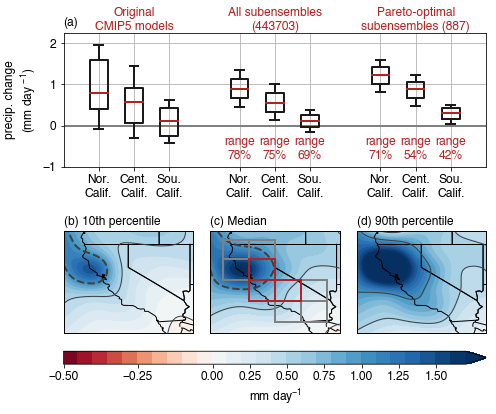

In [27]:
fontsize=12

fig = mp.figure(figsize=(7,6))

field_list = [lo_map_PO, median_map_PO, hi_map_PO]
file_name = 'pareto_optimal_percentiles_for_combo_3d_front.pdf'
figure_text = ['(b) '+str(lo_perc)+'th percentile','(c) Median','(d) '+str(hi_perc)+'th percentile']

ax_top = mp.subplot2grid((5,6),(0,0),colspan=6,rowspan=2)

ax_top.axhline(0,lw=2,c='0.5', zorder=1)

boxplot_width=[0.5]

flierprops = dict(marker='.', markeredgecolor='0.1', markerfacecolor='0.1')
medianprops = dict(linewidth=2, color='firebrick')
boxprops = dict(linewidth=2, color='0.1')
whiskerprops = dict(linewidth=2, color='0.1')
capprops = dict(linewidth=2, color='0.1')

whisk_range = [lo_perc, hi_perc]
#whisk_range = 'range'

ax_top.boxplot(model_delta_pr_ncal, zorder=2, positions=[1.0], whis=whisk_range, showfliers=False, widths=boxplot_width, flierprops=flierprops, medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)
ax_top.boxplot(model_delta_pr_ccal, zorder=2, positions=[2.0], whis=whisk_range, showfliers=False, widths=boxplot_width, flierprops=flierprops, medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)
ax_top.boxplot(model_delta_pr_scal, zorder=2, positions=[3.0], whis=whisk_range, showfliers=False, widths=boxplot_width, flierprops=flierprops, medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)

ax_top.text(s='Original\nCMIP5 models', x=2.0, y=2.25, fontsize=fontsize, ha='center', va='bottom', color='firebrick')

ax_top.text(s='(a)',x=0.0,y=1.03,ha='left',va='bottom',transform=ax_top.transAxes,fontsize=fontsize)

flierprops = dict(marker='.', markeredgecolor='0.1', markerfacecolor='0.1')
medianprops = dict(linewidth=2, color='firebrick')
boxprops = dict(linewidth=2, color='0.1')
whiskerprops = dict(linewidth=2, color='0.1')
capprops = dict(linewidth=2, color='0.1')

ax_top.boxplot(subensembles_delta_pr_ncal, zorder=2, positions=[5.0], whis=whisk_range, showfliers=False, widths=boxplot_width, flierprops=flierprops, medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)
ax_top.boxplot(subensembles_delta_pr_ccal, zorder=2, positions=[6.0], whis=whisk_range, showfliers=False, widths=boxplot_width, flierprops=flierprops, medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)
ax_top.boxplot(subensembles_delta_pr_scal, zorder=2, positions=[7.0], whis=whisk_range, showfliers=False, widths=boxplot_width, flierprops=flierprops, medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)

ax_top.text(s='All subensembles\n('+str(N_ens)+')', x=6.0, y=2.25, fontsize=fontsize, ha='center', va='bottom', color='firebrick')

flierprops = dict(marker='+', s=1e-5, markeredgecolor='0.1', markerfacecolor='0.1')
medianprops = dict(linewidth=2, color='firebrick')
boxprops = dict(linewidth=2, color='0.1')
whiskerprops = dict(linewidth=2, color='0.1')
capprops = dict(linewidth=2, color='0.1')

ax_top.boxplot(optimal_subensembles_delta_pr_ncal, zorder=2, positions=[9.0], whis=whisk_range, showfliers=False, widths=boxplot_width, flierprops=flierprops, medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)
ax_top.boxplot(optimal_subensembles_delta_pr_ccal, zorder=2, positions=[10.0], whis=whisk_range, showfliers=False, widths=boxplot_width, flierprops=flierprops, medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)
ax_top.boxplot(optimal_subensembles_delta_pr_scal, zorder=2, positions=[11.0], whis=whisk_range, showfliers=False, widths=boxplot_width, flierprops=flierprops, medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)

# calculate percent change in range
ncal_fraction_all = (subensembles_delta_pr_ncal.max()-optimal_subensembles_delta_pr_ncal.min())/(model_delta_pr_ncal.max()-model_delta_pr_ncal.min())*100.
ccal_fraction_all = (subensembles_delta_pr_ccal.max()-optimal_subensembles_delta_pr_ccal.min())/(model_delta_pr_ccal.max()-model_delta_pr_ccal.min())*100.
scal_fraction_all = (subensembles_delta_pr_scal.max()-optimal_subensembles_delta_pr_scal.min())/(model_delta_pr_scal.max()-model_delta_pr_scal.min())*100.

ncal_fraction_po = (optimal_subensembles_delta_pr_ncal.max()-optimal_subensembles_delta_pr_ncal.min())/(model_delta_pr_ncal.max()-model_delta_pr_ncal.min())*100.
ccal_fraction_po = (optimal_subensembles_delta_pr_ccal.max()-optimal_subensembles_delta_pr_ccal.min())/(model_delta_pr_ccal.max()-model_delta_pr_ccal.min())*100.
scal_fraction_po = (optimal_subensembles_delta_pr_scal.max()-optimal_subensembles_delta_pr_scal.min())/(model_delta_pr_scal.max()-model_delta_pr_scal.min())*100.

ax_top.text(s='range\n'+'{:.0f}'.format(ncal_fraction_all)+'%', x=5.0, y=-0.25, fontsize=fontsize, ha='center', va='top', color='firebrick')
ax_top.text(s='range\n'+'{:.0f}'.format(ccal_fraction_all)+'%', x=6.0, y=-0.25, fontsize=fontsize, ha='center', va='top', color='firebrick')
ax_top.text(s='range\n'+'{:.0f}'.format(scal_fraction_all)+'%', x=7.0, y=-0.25, fontsize=fontsize, ha='center', va='top', color='firebrick')

ax_top.text(s='range\n'+'{:.0f}'.format(ncal_fraction_po)+'%', x=9.0, y=-0.25, fontsize=fontsize, ha='center', va='top', color='firebrick')
ax_top.text(s='range\n'+'{:.0f}'.format(ccal_fraction_po)+'%', x=10.0, y=-0.25, fontsize=fontsize, ha='center', va='top', color='firebrick')
ax_top.text(s='range\n'+'{:.0f}'.format(scal_fraction_po)+'%', x=11.0, y=-0.25, fontsize=fontsize, ha='center', va='top', color='firebrick')

ax_top.text(s='Pareto-optimal\nsubensembles ('+str(len(optimal_subensembles))+')', x=10.0, y=2.25, fontsize=fontsize, ha='center', va='bottom', color='firebrick')

ax_top.set_xlim(0,12)
ax_top.set_ylim(-1,2.25)
ax_top.tick_params(labelsize=fontsize)
ax_top.set_ylabel('precip. change\n(mm day$^{\, -1}$)', fontsize=fontsize)
ax_top.set_xticklabels(['Nor.\nCalif.', 'Cent.\nCalif.', 'Sou.\nCalif.']*3)
ax_top.set_xticks([1,2,3,5,6,7,9,10,11])
ax_top.grid()
ax_top.set_axisbelow(True)

ax_list = []
contour_levels = numpy.hstack((numpy.arange(-0.5,0,0.05), numpy.arange(0,1.8,0.1)))

for i in range(3):
    
    ax = mp.subplot2grid((5,6),(2,2*i),colspan=2,rowspan=2)

    ax.text(s=figure_text[i],x=0.0,y=1.03,ha='left',va='bottom',transform=ax.transAxes,fontsize=fontsize)

    map = basemap.Basemap(projection='cea',llcrnrlat=dict_pr['lats'].min(),\
                          urcrnrlat=dict_pr['lats'].max(),\
                          llcrnrlon=dict_pr['lons'].min(),\
                          urcrnrlon=dict_pr['lons'].max(),\
                          resolution='l')

    map.drawcoastlines(linewidth=1, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
    map.drawmapboundary(linewidth=1, color='0')
    map.drawstates(linewidth=1, color='0')
    map.drawcountries(linewidth=1, color='0')

    lons,lats = numpy.meshgrid(dict_pr['lons'], dict_pr['lats'])
    field = field_list[i]
    xi,yi = map(lons, lats)
    xi_smooth = scipy.ndimage.zoom(xi,10)
    yi_smooth = scipy.ndimage.zoom(yi,10)
    field_smooth = scipy.ndimage.zoom(field,10)

    pr_map = map.contourf(xi_smooth, \
                          yi_smooth, \
                          field_smooth, \
                          levels=contour_levels, \
                          extend='max', \
                          norm=MidpointNormalize(midpoint=0), \
                          cmap='RdBu')
    
    pr_map_contourlines = map.contour(xi_smooth, \
                           yi_smooth, \
                           field_smooth, \
                           levels=[-1,-0.5,0,0.5,1.], \
                           linestyles=['-']*2+['--']+['-']*2, \
                           linewidths=[1]*2+[2]+[1]*2, \
                           colors=['0.25']*5)

    for c in pr_map.collections:
        c.set_edgecolor("face")
    
    if i==1:
    #if i==0:
        for gp in range(3):
            lat_val = ncal_latlon[gp,1]
            lon_val = ncal_latlon[gp,0]
            x1,y1 = map(lon_val-1.25, lat_val-1.25)
            x2,y2 = map(lon_val-1.25, lat_val+1.25)
            x3,y3 = map(lon_val+1.25, lat_val+1.25)
            x4,y4 = map(lon_val+1.25, lat_val-1.25)
            poly = matplotlib.patches.Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)],\
                                              facecolor='None', edgecolor='0.5',\
                                              linewidth=2,linestyle='-',zorder=2)
            ax.add_patch(poly)   
    #elif i==2:
        for gp in range(3):
            lat_val = scal_latlon[gp,1]
            lon_val = scal_latlon[gp,0]
            x1,y1 = map(lon_val-1.25, lat_val-1.25)
            x2,y2 = map(lon_val-1.25, lat_val+1.25)
            x3,y3 = map(lon_val+1.25, lat_val+1.25)
            x4,y4 = map(lon_val+1.25, lat_val-1.25)
            poly = matplotlib.patches.Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)],\
                                              facecolor='None', edgecolor='0.5',\
                                              linewidth=2,linestyle='-',zorder=2)
            ax.add_patch(poly)
        #elif i==1:
        for gp in range(3):
            lat_val = ccal_latlon[gp,1]
            lon_val = ccal_latlon[gp,0]
            x1,y1 = map(lon_val-1.25, lat_val-1.25)
            x2,y2 = map(lon_val-1.25, lat_val+1.25)
            x3,y3 = map(lon_val+1.25, lat_val+1.25)
            x4,y4 = map(lon_val+1.25, lat_val-1.25)
            poly = matplotlib.patches.Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)],\
                                              facecolor='None', edgecolor='firebrick',\
                                              linewidth=2,linestyle='-',zorder=2)
            ax.add_patch(poly) 

fig.tight_layout(h_pad=2.5, w_pad=1)

bbox = ax_top.get_position()
cbar_axes = fig.add_axes([bbox.x0, 0.2, bbox.x1-bbox.x0, 0.03])#, transform=ax_top.transAxes)
cbar = mp.colorbar(pr_map, orientation='horizontal', cax=cbar_axes)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label('mm day$^{-1}$', fontsize=fontsize)
cbar.set_ticks(numpy.arange(-0.5,1.51,0.25))
cbar.solids.set_edgecolor("face")

fig.savefig('panel_maps_and_box_plots_'+DATESTRING+'_whiskers_hilo_SMALL_index_domains_k1to5.pdf', transparent=True, bbox_inches='tight')


In [31]:
save_dict = {}

save_dict['model_delta_pr_ncal'] = model_delta_pr_ncal
save_dict['model_delta_pr_ccal'] = model_delta_pr_ccal
save_dict['model_delta_pr_scal'] = model_delta_pr_scal

save_dict['subensembles_delta_pr_ncal'] = subensembles_delta_pr_ncal
save_dict['subensembles_delta_pr_ccal'] = subensembles_delta_pr_ccal
save_dict['subensembles_delta_pr_scal'] = subensembles_delta_pr_scal

save_dict['optimal_subensembles_delta_pr_ncal'] = optimal_subensembles_delta_pr_ncal
save_dict['optimal_subensembles_delta_pr_ccal'] = optimal_subensembles_delta_pr_ccal
save_dict['optimal_subensembles_delta_pr_scal'] = optimal_subensembles_delta_pr_scal

save_dict['ncal_fraction_all'] = ncal_fraction_all
save_dict['ccal_fraction_all'] = ccal_fraction_all
save_dict['scal_fraction_all'] = scal_fraction_all

save_dict['ncal_fraction_po'] = ncal_fraction_po
save_dict['ccal_fraction_po'] = ccal_fraction_po
save_dict['scal_fraction_po'] = scal_fraction_po

save_dict['N_ens'] = N_ens
save_dict['optimal_subensembles'] = optimal_subensembles

numpy.save('../../../DATA/subensemble_data/index_domain_info_k1to5_emergent_constraint_domains.npy', save_dict)

# Plot only maps for the SI

/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


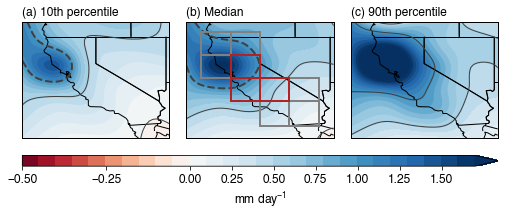

In [29]:
fontsize=12

fig = mp.figure(figsize=(7,3))

field_list = [lo_map_PO, median_map_PO, hi_map_PO]
file_name = 'pareto_optimal_percentiles_for_combo_3d_front.pdf'
figure_text = ['(a) '+str(lo_perc)+'th percentile','(b) Median','(c) '+str(hi_perc)+'th percentile']

ax_left = mp.subplot2grid((3,6),(0,0),colspan=2,rowspan=2)
ax_center = mp.subplot2grid((3,6),(0,2),colspan=2,rowspan=2)
ax_right = mp.subplot2grid((3,6),(0,4),colspan=2,rowspan=2)

axes = [ax_left, ax_center, ax_right]

for i in range(3):
    
    ax = axes[i]

    ax.text(s=figure_text[i],x=0.0,y=1.03,ha='left',va='bottom',transform=ax.transAxes,fontsize=fontsize)

    map = basemap.Basemap(projection='cea',llcrnrlat=dict_pr['lats'].min(),\
                          urcrnrlat=dict_pr['lats'].max(),\
                          llcrnrlon=dict_pr['lons'].min(),\
                          urcrnrlon=dict_pr['lons'].max(),\
                          resolution='l',
                          ax=ax)

    map.drawcoastlines(linewidth=1, color='0') # you can specify white as 1.0, black as 0.0, and any gray as fraction
    map.drawmapboundary(linewidth=1, color='0')
    map.drawstates(linewidth=1, color='0')
    map.drawcountries(linewidth=1, color='0')

    lons,lats = numpy.meshgrid(dict_pr['lons'], dict_pr['lats'])
    field = field_list[i]
    xi,yi = map(lons, lats)
    
    xi_smooth = scipy.ndimage.zoom(xi,10)
    yi_smooth = scipy.ndimage.zoom(yi,10)
    field_smooth = scipy.ndimage.zoom(field,10)

    pr_map = map.contourf(xi_smooth, \
                          yi_smooth, \
                          field_smooth, \
                          levels=contour_levels, \
                          extend='max', \
                          norm=MidpointNormalize(midpoint=0), \
                          cmap='RdBu')
    
    pr_map_contourlines = map.contour(xi_smooth, \
                           yi_smooth, \
                           field_smooth, \
                           levels=[-1,-0.5,0,0.5,1.], \
                           linestyles=['-']*2+['--']+['-']*2, \
                           linewidths=[1]*2+[2]+[1]*2, \
                           colors=['0.25']*5)

    for c in pr_map.collections:
        c.set_edgecolor("face")
    
    if i==1:
    #if i==0:
        for gp in range(3):
            lat_val = ncal_latlon[gp,1]
            lon_val = ncal_latlon[gp,0]
            x1,y1 = map(lon_val-1.25, lat_val-1.25)
            x2,y2 = map(lon_val-1.25, lat_val+1.25)
            x3,y3 = map(lon_val+1.25, lat_val+1.25)
            x4,y4 = map(lon_val+1.25, lat_val-1.25)
            poly = matplotlib.patches.Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)],\
                                              facecolor='None', edgecolor='0.5',\
                                              linewidth=2,linestyle='-',zorder=2)
            ax.add_patch(poly)   
    #elif i==2:
        for gp in range(3):
            lat_val = scal_latlon[gp,1]
            lon_val = scal_latlon[gp,0]
            x1,y1 = map(lon_val-1.25, lat_val-1.25)
            x2,y2 = map(lon_val-1.25, lat_val+1.25)
            x3,y3 = map(lon_val+1.25, lat_val+1.25)
            x4,y4 = map(lon_val+1.25, lat_val-1.25)
            poly = matplotlib.patches.Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)],\
                                              facecolor='None', edgecolor='0.5',\
                                              linewidth=2,linestyle='-',zorder=2)
            ax.add_patch(poly)
        #elif i==1:
        for gp in range(3):
            lat_val = ccal_latlon[gp,1]
            lon_val = ccal_latlon[gp,0]
            x1,y1 = map(lon_val-1.25, lat_val-1.25)
            x2,y2 = map(lon_val-1.25, lat_val+1.25)
            x3,y3 = map(lon_val+1.25, lat_val+1.25)
            x4,y4 = map(lon_val+1.25, lat_val-1.25)
            poly = matplotlib.patches.Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)],\
                                              facecolor='None', edgecolor='firebrick',\
                                              linewidth=2,linestyle='-',zorder=2)
            ax.add_patch(poly) 

fig.tight_layout(h_pad=2.5, w_pad=1)


bbox_left = ax_left.get_position()
bbox_right = ax_right.get_position()
cbar_axes = fig.add_axes([bbox_left.x0, 0.27, bbox_right.x1-bbox_left.x0, 0.05])#, transform=ax_top.transAxes)
cbar = mp.colorbar(pr_map, orientation='horizontal', cax=cbar_axes)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label('mm day$^{-1}$', fontsize=fontsize)
cbar.set_ticks(numpy.arange(-0.5,1.51,0.25))
cbar.solids.set_edgecolor("face")

fig.savefig('SI_maps_from_fig4_'+DATESTRING+'_SMALL_index_domains_k1to5.pdf', transparent=True, dpi=1200, bbox_inches='tight')
